In [1]:
#from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import joblib
from typing import List, Tuple
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import sys

from codicem.timings_type import *
from codicem.util import *
from codicem.experiment import *
from codicem.morsenet import MorseNet


2024-03-12 14:42:29.373808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 14:42:29.373840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 14:42:29.374839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 14:42:29.382234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 14:42:30.464096: W tensorflow/compiler/tf2

In [2]:
train, _ = load_timings_set("/home/braddock/expire/morse/new-train", num_sets=20000)
test, _ = load_timings_set("/home/braddock/expire/morse/new-test")
(len(train), len(test))

(20000, 2000)

In [3]:
# net = MorseNet()  # Only instantiating for normalization function
# train = [net.normalize(t) for t in train]
# test = [net.normalize(t) for t in test]

In [4]:
X_marks, labels_marks, _ = prep_data_for_ml(train, True)
X_spaces, labels_spaces, labels_word_spaces = prep_data_for_ml(train, False)

In [5]:
rf_marks = RandomForestClassifier(n_estimators=10)
rf_spaces = RandomForestClassifier(n_estimators=10)
# A separate classifier is used for word spaces because they are rare
# and are usually miscategorized by the rf_spaces model
# NOTE THIS DOES NOT WORK, IT NEVER LEARNS THE 2% OF TIMINGS THAT ARE WORD SPACES
# RETURNING PREDICTIONS OF ALL ZERO MAYBE IT IS A TRAIN DATA PROBLEM
rf_word_spaces = RandomForestClassifier(n_estimators=10)

In [6]:
rf_marks.fit(X_marks, labels_marks)
rf_spaces.fit(X_spaces, labels_spaces)
rf_word_spaces.fit(X_spaces, labels_word_spaces)

RandomForestClassifier(n_estimators=10)

In [7]:
joblib.dump([rf_marks, rf_spaces], "rf.joblib")

['rf.joblib']

In [8]:
test_marks, test_labels_marks, _ = prep_data_for_ml(test, True)
test_spaces, test_labels_spaces, test_labels_word_spaces = prep_data_for_ml(test, False)

In [9]:
predicted_marks = rf_marks.predict(test_marks)
predicted_spaces = rf_spaces.predict(test_spaces)
predicted_word_spaces = rf_word_spaces.predict(test_spaces)


In [10]:
predicted_spaces[:20], test_labels_spaces[:20], np.mean(labels_word_spaces)

(array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
 0.027625534044797197)

In [11]:
marks_accuracy = np.mean(predicted_marks == test_labels_marks)
spaces_accuracy = np.mean(predicted_spaces == test_labels_spaces)
word_spaces_accuracy = np.mean(predicted_word_spaces == test_labels_word_spaces)
print("Marks accuracy:", marks_accuracy,
      " Spaces accuracy:", spaces_accuracy,
      " Word Spaces accurage:", word_spaces_accuracy)
combined_spaces = np.array(predicted_spaces)
combined_spaces[predicted_word_spaces == 1] = label_lookup_spaces[WORD_SPACE]
combined_spaces_accuracy = np.mean(combined_spaces == test_labels_spaces)
print("Combined spaces accurace:", combined_spaces_accuracy)

Marks accuracy: 0.9506880328274788  Spaces accuracy: 0.9639448948841214  Word Spaces accurage: 0.9841788046207935
Combined spaces accurace: 0.9639448948841214


In [12]:
# Random forest with 100 estimators and 200,000 training sets
# Marks accuracy: 0.9505111606353249  Spaces accuracy: 0.9640883977900553
# Random forest with 20 estimators and 200,000 training sets
# Marks accuracy: 0.9505111606353249  Spaces accuracy: 0.9640525220635718

In [13]:

dd, _ = timings2dashdots(train[10])
print(dd)

#dashdots2string(dd), dd, ''.join([t.label for t in train[10]])

['.----', '.--', '..-']


In [14]:
predicted_timings = predicted2timings(test[:1000], predicted_marks, predicted_spaces)
predicted_timings = [timings2dashdots(t)[1] for t in predicted_timings]
correct = score_timing_sets(test[:1000], predicted_timings)
accuracy = np.mean(correct)
accuracy

['.-.-.-', '...', '.-..', '-.-.'] vs ['.-.-.-', '...', '.-..']
['-....', '--..--', '--..', ' '] vs ['-....', '--..--', '--..']
['-..-', '---', '.--.', '--'] vs ['-..-', '---', '.--.', '--']
['.--.', '--..--', '--.', '.-'] vs ['.--.', '--...-', '--.', '.-']
['.-..', '..', '.', '-'] vs ['.-..', '-.', '-', '-']
['-.-', ' ', '-.--....', '-....-'] vs ['-.-', '-....', '-....-']
[' ', '--.', '-.-.'] vs ['', '.-.-.-.']
['...-', '--..', '----.', '-....'] vs ['...-', '.-..', '----.', '-....']
['---', '-....-', '.....', '-----'] vs ['---', '-....-', '.....', '-----']
['.-..', ' ', '.-..-....-', '-.-.'] vs ['.-..', ' ', '.-..-....-']
['..---', '.--.', ' ', '.--......'] vs ['..---', '.--.', '.....']
[' ', '-.--', '-..-', '--'] vs ['', '-.--']
['.--.-.', ' ', '.--.-..----', '--'] vs ['.-..-.', ' ', '.-..-..-..-', '--']
['--.-', ' ', '--.-.--.-.', '.-..'] vs ['--.-', '.--...', '.-..']
['-...', '....-', '-....-', '-----'] vs ['-...', '....-', '-....-', '-----']
[' ', '---...', ' ', '---....-.-.-'] vs 

0.646

In [15]:
# save_timings(sys.stdout, predicted_timings[2], "PREDICT")
# print("----------------------------")
# save_timings(sys.stdout, test[2], "TEST")

In [16]:
np.mean(predicted_spaces == 2), np.mean(np.array(labels_spaces, dtype=int) == 2)

(0.01528305948195451, 0.027625534044797197)

In [17]:
def separate(X_marks, X_spaces, labels_marks, labels_spaces):
    X_marks = X_marks.reshape(-1)
    X_spaces = X_spaces.reshape(-1)
    labels_marks = np.array(labels_marks)
    labels_spaces = np.array(labels_spaces)

    durations = {}
    for sym in marks_stypes + spaces_stypes:
        is_on = sym in marks_stypes
        label_lookup = label_lookup_marks if is_on else label_lookup_spaces
        labels = labels_marks if is_on else labels_spaces
        X = X_marks if is_on else X_spaces
        durations[sym] = X[labels == label_lookup[sym]]
    return durations




In [18]:
durations = separate(X_marks, X_spaces, labels_marks, labels_spaces)
durations

{'.': array([0.43, 0.82, 0.82, ..., 0.38, 0.35, 0.57]),
 '-': array([4.8 , 4.62, 1.11, ..., 0.73, 2.95, 3.62]),
 's': array([1.56, 0.77, 0.73, ..., 1.1 , 0.25, 1.47]),
 'c': array([6.49, 2.94, 4.24, ..., 3.23, 3.38, 2.48]),
 '_': array([8.27, 6.36, 7.52, ..., 6.1 , 7.51, 8.11])}

In [19]:
durations = separate_durations_by_stype(train)
durations

{'.': array([0.43, 0.82, 0.82, ..., 0.38, 0.35, 0.57]),
 '-': array([4.8 , 4.62, 1.11, ..., 0.73, 2.95, 3.62]),
 's': array([1.56, 0.77, 0.73, ..., 1.1 , 0.25, 1.47]),
 'c': array([6.49, 2.94, 4.24, ..., 3.23, 3.38, 2.48]),
 '_': array([8.27, 6.36, 7.52, ..., 6.1 , 7.51, 8.11])}

In [20]:
for sym, dt in durations.items():
    print(f"Mean of {sym} = {np.mean(dt)}, min = {np.min(dt)}, max = {np.max(dt)}")

Mean of . = 0.4967904724000458, min = 0.04, max = 3.55
Mean of - = 2.750059411068363, min = 0.44, max = 10.59
Mean of s = 1.0495787981549347, min = 0.07, max = 3.43
Mean of c = 3.796677570271196, min = 0.79, max = 8.23
Mean of _ = 6.417020836029507, min = 1.29, max = 12.01


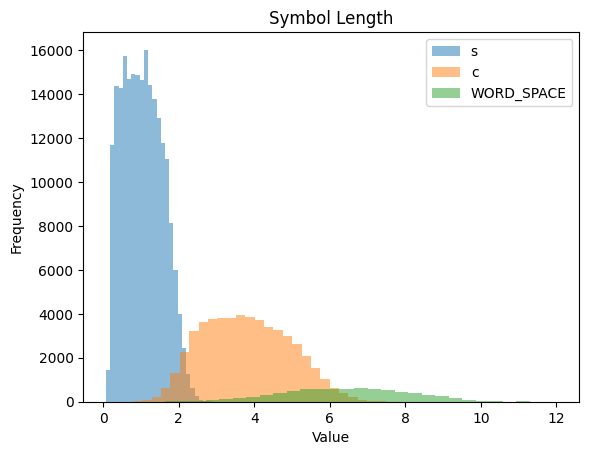

In [24]:
plot_durations(durations, spaces_stypes)